### **IMPORTS AND LIBRARY SETUP**

*This cell imports all required libraries for the LSTM-based stock prediction system.*

**Key purposes:**
- pandas / numpy → data handling and numerical operations
- torch / torch.nn → building and training the LSTM neural network
- sklearn.preprocessing → feature scaling using MinMaxScaler
- sklearn.metrics → evaluation metrics (RMSE, MAE, R²)
- matplotlib → visualization of predicted vs actual prices
- yfinance → downloading Reliance stock data from Yahoo Finance
- Dataset/DataLoader → efficient batching for PyTorch training

**This cell must run first since all later cells depend on these imports.**

In [1]:
import pandas as pd
import numpy as np
import torch
import joblib
import yfinance as yf
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### **DATA COLLECTION FROM YAHOO FINANCE**

*This cell downloads historical stock price data for Reliance Industries
using the yfinance API.*

**Configuration:**
- ticker = RELIANCE.NS (NSE listing)
- period = last 9 years
- interval = daily data

The downloaded dataset is saved locally as **'reliance.csv'**
so the project can be reproduced without downloading again.

**Output:**
CSV file containing Date, Open, High, Low, Close, Volume columns.

In [2]:
ticker = "RELIANCE.NS"
df = yf.download(ticker, period="9y", interval="1d")
df.to_csv("reliance.csv")

/tmp/ipython-input-2490224290.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="9y", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2017-02-16,233.914429,234.341722,230.638537,230.638537,19655195
2017-02-17,235.667435,236.259081,231.931381,233.695335,14847356
2017-02-20,235.645523,236.401507,233.695335,234.582775,11650581
2017-02-21,238.450317,239.052905,235.130587,235.601704,14186476
2017-02-22,264.591736,265.501087,239.282952,239.502084,127323130


### **DATA CLEANING AND PREPROCESSING**

*This cell loads the downloaded CSV file and prepares it for modeling.*

**Steps performed:**
1. Remove extra Yahoo header rows if present
2. Rename the first column to 'Date'
3. Convert Date column to datetime format
4. Convert price and volume columns to numeric type
5. Sort dataset chronologically (important for time-series learning)

The cleaned dataframe is now ready for train/test splitting.

In [4]:
df = pd.read_csv("reliance.csv")
df = df.iloc[2:].copy()
df.rename(columns={'Price':'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
cols = ['Open','High','Low','Close','Volume']
df[cols] = df[cols].astype(float)
df = df.sort_values('Date').reset_index(drop=True)
df.head()

,Date,Close,High,Low,Open,Volume
0,2017-02-16,233.914429,234.341722,230.638537,230.638537,19655195.0
1,2017-02-17,235.667435,236.259081,231.931381,233.695335,14847356.0
2,2017-02-20,235.645523,236.401507,233.695335,234.582775,11650581.0
3,2017-02-21,238.450317,239.052905,235.130587,235.601704,14186476.0
4,2017-02-22,264.591736,265.501087,239.282952,239.502084,127323130.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2224 non-null   datetime64[ns]
 1   Close   2224 non-null   float64       
 2   High    2224 non-null   float64       
 3   Low     2224 non-null   float64       
 4   Open    2224 non-null   float64       
 5   Volume  2224 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 104.4 KB


### **TIME-SERIES TRAIN/TEST SPLIT**

*This cell splits the dataset chronologically:*

- First 7/9 of data → training set
- Remaining 2/9 → testing set

This preserves time order and prevents data leakage,
which is critical for financial forecasting problems.

**Outputs:**
train_df → used for fitting model
test_df  → used only for evaluation

In [6]:
split_idx = int(len(df)*7/9)
train = df.iloc[:split_idx]
test  = df.iloc[split_idx:]

print("Train:", len(train))
print("Test :", len(test))

Train: 1729
Test : 495


### **FEATURE SCALING USING MINMAXSCALER**

*Neural networks perform better when input values are normalized.*

**This cell:**
1. Selects OHLCV features (Open, High, Low, Close, Volume)
2. Fits MinMaxScaler ONLY on training data
3. Applies same scaler to test data

**Important:**
Fitting only on training data avoids information leakage.

In [7]:
features = ['Open','High','Low','Close','Volume']

scaler = MinMaxScaler()

train_scl = scaler.fit_transform(train[features])
test_scl  = scaler.transform(test[features])

### **SEQUENCE (WINDOW) GENERATION FOR LSTM**

*LSTM models require sequential input.*

**This cell converts scaled data into sliding windows:**

- SEQ_LEN = 20 → model sees last 20 days
- TARGET = next day's Close price

**Special handling:**
Test sequences include last training window to provide
historical context for first prediction.

**Outputs:**
X_train, y_train
X_test, y_test

In [8]:
SEQ_LEN = 20
TARGET_COL = 3

def create_sequences(df):
    X, y = [], []
    for i in range(len(df)-SEQ_LEN):
        X.append(df[i:i+SEQ_LEN])
        y.append(df[i+SEQ_LEN, TARGET_COL])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scl)

combined = np.vstack([train_scl[-SEQ_LEN:], test_scl])
X_test, y_test = create_sequences(combined)

print(X_train.shape, X_test.shape)

(1709, 20, 5) (495, 20, 5)


### **PYTORCH DATASET CLASS**

*Defines a custom Dataset wrapper for stock sequences.*

**Responsibilities:**
- Converts numpy arrays to PyTorch tensors
- Enables indexing and batching
- Works with DataLoader for efficient training

This abstraction separates data handling from model logic.

In [9]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### **DATALOADER INITIALIZATION**

*Creates PyTorch DataLoader objects for training and testing.*

**Benefits:**
- automatic batching
- memory efficiency
- cleaner training loop structure

shuffle=False is used because time-series order must be preserved.

In [10]:
train_loader = DataLoader(StockDataset(X_train,y_train), batch_size=32, shuffle=False)
test_loader  = DataLoader(StockDataset(X_test,y_test), batch_size=32, shuffle=False)

### **LSTM MODEL ARCHITECTURE**

*Defines the neural network used for stock prediction.*

**Structure:**
- Multi-layer LSTM network processes sequential input
- Final timestep output represents learned temporal features
- Fully connected layer converts features into price prediction

**Input shape:**
(batch_size, sequence_length, features)

**Output:**
Predicted next-day closing price

In [11]:
class LSTM(nn.Module):

    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x):
        out,_ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out.squeeze()

### **MODEL INITIALIZATION AND TRAINING SETUP**

*This cell prepares training configuration:*

- Detects GPU if available, otherwise uses CPU
- Instantiates LSTM model
- Defines loss function **(Mean Squared Error)**
- Initializes Adam optimizer for gradient descent

These components control how the model learns.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTM().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **MODEL TRAINING LOOP**

*This cell performs iterative training of the LSTM model.*

**For each epoch:**
1. Switch model to training mode
2. Forward pass on each batch
3. Compute prediction error (MSE)
4. Backpropagate gradients
5. Update model weights via optimizer

Loss printed each epoch helps monitor convergence.

In [13]:
EPOCHS = 25

for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for Xb, yb in train_loader:

        Xb = Xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.6f}")

Epoch 1 Loss: 0.005780
Epoch 2 Loss: 0.050446
Epoch 3 Loss: 0.020988
Epoch 4 Loss: 0.006068
Epoch 5 Loss: 0.000982
Epoch 6 Loss: 0.001195
Epoch 7 Loss: 0.000980
Epoch 8 Loss: 0.000927
Epoch 9 Loss: 0.000828
Epoch 10 Loss: 0.000785
Epoch 11 Loss: 0.000737
Epoch 12 Loss: 0.000706
Epoch 13 Loss: 0.000676
Epoch 14 Loss: 0.000651
Epoch 15 Loss: 0.000626
Epoch 16 Loss: 0.000605
Epoch 17 Loss: 0.000583
Epoch 18 Loss: 0.000564
Epoch 19 Loss: 0.000545
Epoch 20 Loss: 0.000527
Epoch 21 Loss: 0.000511
Epoch 22 Loss: 0.000496
Epoch 23 Loss: 0.000482
Epoch 24 Loss: 0.000470
Epoch 25 Loss: 0.000460


### **MODEL INFERENCE ON TEST DATA**

*After training, the model is evaluated on unseen test data.*

**Steps:**
- Switch model to evaluation mode
- Disable gradient computation for efficiency
- Generate predictions batch-by-batch
- Combine predictions into a single array

Predictions are still in scaled units at this stage.

In [14]:
model.eval()

preds = []

with torch.no_grad():
    for Xb,_ in test_loader:
        Xb = Xb.to(device)
        preds.append(model(Xb).cpu().numpy())

preds = np.concatenate(preds)

### **INVERSE SCALING OF PREDICTIONS**

Since the model was trained on normalized data,
predictions must be transformed back to real price values.

A dummy feature matrix is created so MinMaxScaler
can perform inverse transformation correctly.

**Output:**
pred_prices → predicted closing prices in original rupees.

In [15]:
dummy = np.zeros((len(preds),5))
dummy[:,TARGET_COL] = preds

pred_prices = scaler.inverse_transform(dummy)[:,TARGET_COL]

### **EXTRACT ACTUAL TEST PRICES**

Retrieves the real closing prices from the test dataset
aligned with the prediction length.

**These values will be used for:**
- visualization
- evaluation metrics

In [16]:
actual = test['Close'].values[:len(pred_prices)]

### **VISUAL COMPARISON OF ACTUAL VS PREDICTED PRICES**

*This plot provides a visual assessment of model performance.*

**A good model should:**
- follow overall trend
- track major movements
- minimize large deviations

This visualization is important for project reports and presentations.

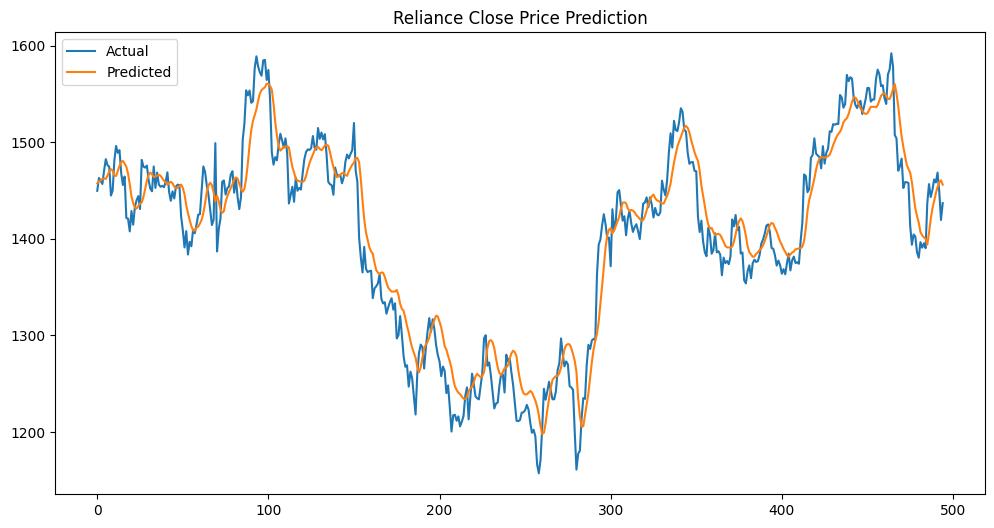

In [17]:
plt.figure(figsize=(12,6))
plt.plot(actual,label="Actual")
plt.plot(pred_prices,label="Predicted")
plt.legend()
plt.title("Reliance Close Price Prediction")
plt.show()

### **MODEL PERFORMANCE EVALUATION**

**Calculates quantitative metrics:**

**RMSE **→ *average prediction error in price units*
**R²  ** → *proportion of variance explained by the model*

Higher R² (closer to 1) indicates better predictive capability.

These metrics provide objective validation of model accuracy.

In [18]:
rmse = np.sqrt(mean_squared_error(actual, pred_prices))
r2 = r2_score(actual, pred_prices)

print(f"RMSE : {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE : 29.41
R² Score: 0.9176
